In [1]:
import pandas as pd
import numpy as np
import collections
import copy
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nlp.utils import (
    plot_histogram,
    get_completetext,
    plot_wordcloud,
    print_statistics,
    groups_frequency_sort)
from nlp.text_statistics import (
    count_tokens,
    unique_tokens
)
from utils.read_files import (
    get_items)
from item.item_list import (
    ItemList,
    Item
)
from item.utils import get_tokens_set

sns.set()

# Termos cujos grupos serão caracterizados:
- gasolina
- álcool
- querosene
- óleo
- etanol
- diesel

In [2]:
termos = [
    "gasolina",
    "alcool",
    "querosene",
    "oleo",
    "etanol",
    "diesel"
]

# Carregar dados de clusters

In [61]:
clusters = pd.read_csv("../dados/output/cluster_prices_statistics_year.csv.zip", sep=';')
items = pd.read_csv("../dados/output/items_clusters_train.csv.zip", sep=';')
items = items[items.outlier != 1] # Desconsiderar outliers

In [11]:
items.head()

,item_id,seq_dim_licitacao,outlier,cluster,dsc_unidade_medida,ano,description,original,areas,price
150,4010,716236,0,achocolatar_24,pacote,2017,achocolatar po 400 gr base acucar cacau maltod...,"Achocolatado em pó de 400gr - ACHOCOLATADO, em...",Vazio,4.33
151,4951,716287,0,achocolatar_24,pacote,2018,achocolatar po 400 gr base acucar cacau maltod...,"Achocolatado em pó de 400gr - ACHOCOLATADO, em...",Vazio,3.88
152,31955,722115,0,achocolatar_24,pacote,2017,achocolatar po ii embalagem 400 g composicao a...,Achocolatado em po II - embalagem 400 g. Compo...,Assistência Social | Educação,2.99
153,158513,749927,0,achocolatar_24,unidade,2015,achocolatar po diet 39 menos caloria 35 cacau ...,ACHOCOLATADO EM PO DIET - Achocolatado em pó d...,Vazio,10.35
154,161886,750062,0,achocolatar_24,unidade,2018,achocolatar po diet 39 menos caloria 35 cacau ...,ACHOCOLATADO EM PO DIET - Achocolatado em pó d...,Vazio,10.90


In [12]:
clusters.head()

,cluster,dsc_unidade_medida,mean,count,max,min,median,std,var,quantile_1,quantile_3
0,a100_0,tb,56.000000,2,56.00,56.00,56.00,0.000000,0.000000,56.000,56.000
1,a100_0,tubo,46.150000,2,60.10,32.20,46.15,19.728279,389.205000,39.175,53.125
2,a100_0,tubos,50.550000,1,50.55,50.55,50.55,NaN,NaN,50.550,50.550
3,a100_0,unidade,46.446615,65,75.75,32.57,44.67,13.922649,193.840151,32.840,55.000
4,a100_0,unidades,40.480000,1,40.48,40.48,40.48,NaN,NaN,40.480,40.480


## Volume por Ano

### Quantidade de grupos por ano

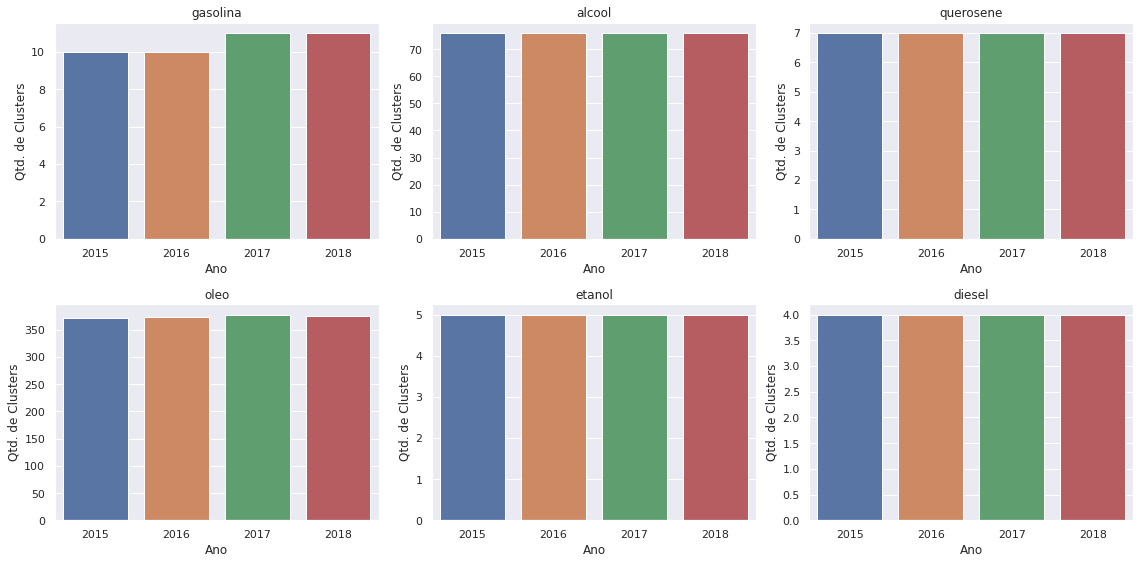

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, termos):
    items_termo = items[items.cluster.str.startswith(termo)]
    qtd_clusters = items_termo.groupby("ano").cluster.unique().apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax)
    ax.set(xlabel="Ano", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()    

## Quantidade de itens nos grupos

Clusters de gasolina; | Mínimo: 26 itens | Máximo: 1805 itens 
Clusters de alcool; | Mínimo: 25 itens | Máximo: 2079 itens 
Clusters de querosene; | Mínimo: 32 itens | Máximo: 173 itens 
Clusters de oleo; | Mínimo: 6 itens | Máximo: 2350 itens 
Clusters de etanol; | Mínimo: 44 itens | Máximo: 516 itens 
Clusters de diesel; | Mínimo: 107 itens | Máximo: 412 itens 


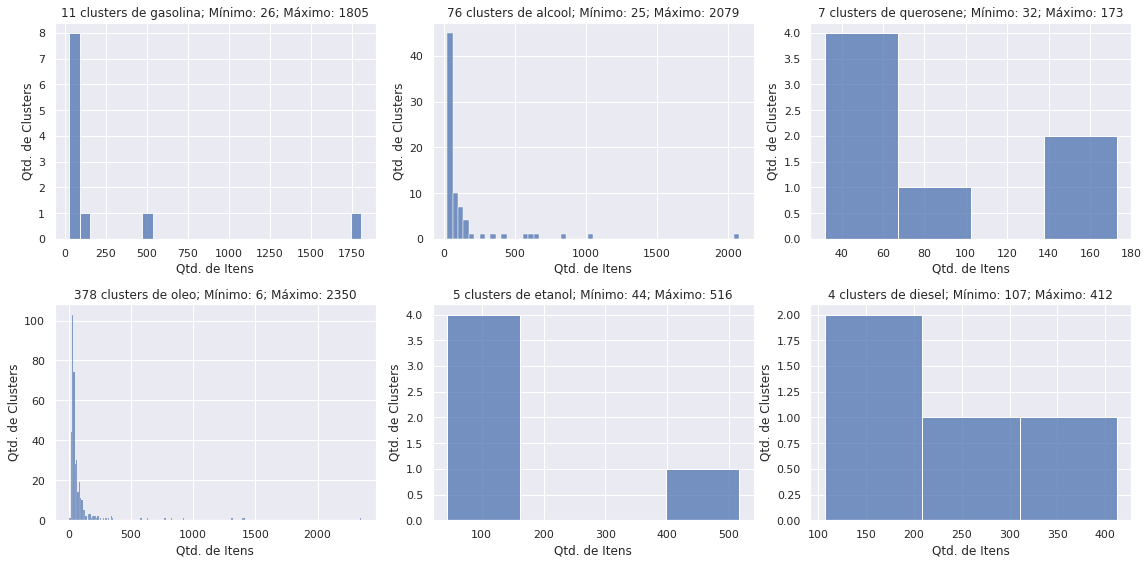

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, termos):
    items_termo = items[items.cluster.str.startswith(termo)]
    qtd_itens = items_termo.groupby("cluster").size()
    print("Clusters de {}; | Mínimo: {} itens | Máximo: {} itens ".format(termo, min(qtd_itens), max(qtd_itens)))
    sns.histplot(x=qtd_itens, ax=ax)
    ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {}; Máximo: {}".format(len(qtd_itens),termo, min(qtd_itens), max(qtd_itens)))
fig.tight_layout()
plt.show()    

## Variações de preço dos grupos

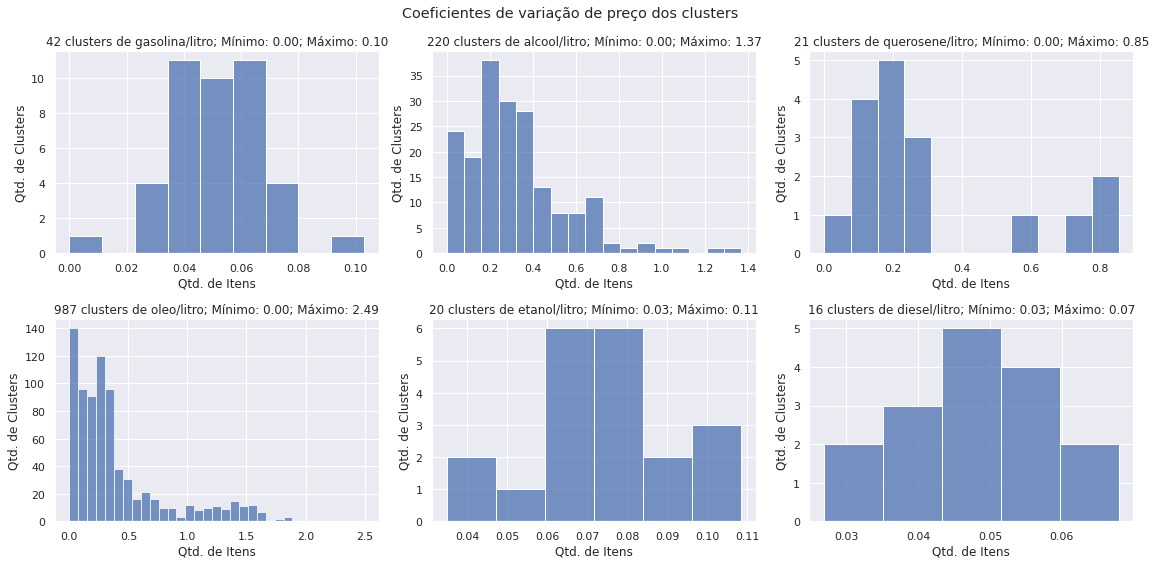

In [74]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, termos):
    clusters_termo = clusters[(clusters.cluster.str.startswith(termo))]
    unidade = "litro"
    clusters_termo = clusters_termo[clusters_termo.dsc_unidade_medida == unidade]
    cv = clusters_termo["std"] / clusters_termo["mean"]
    sns.histplot(x=cv, ax=ax)
    ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}/{}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, unidade, min(cv), max(cv)))
fig.suptitle("Coeficientes de variação de preço dos clusters")
fig.tight_layout()
plt.show()

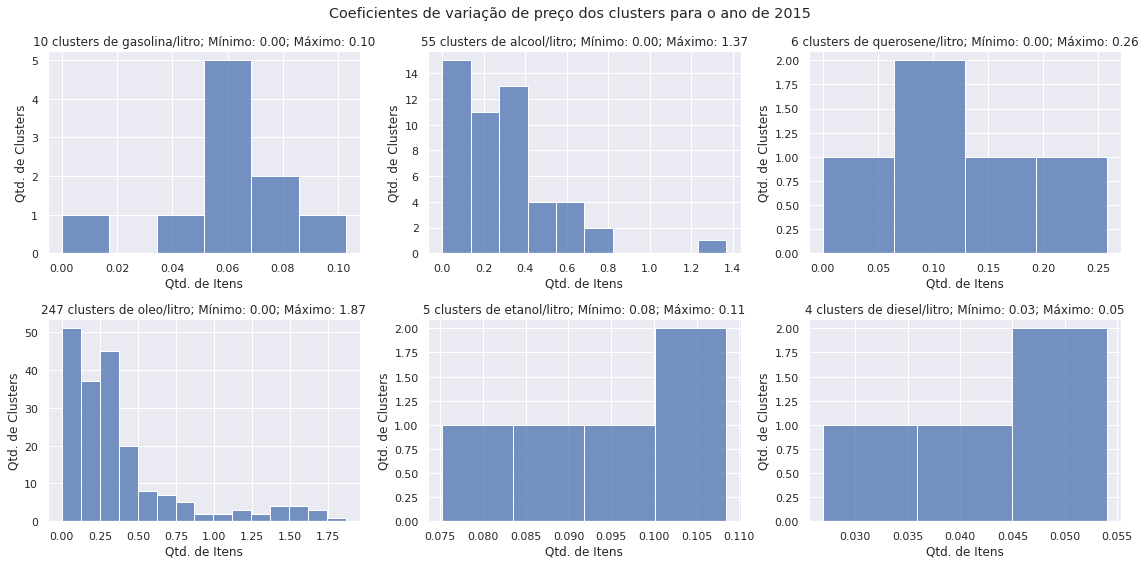

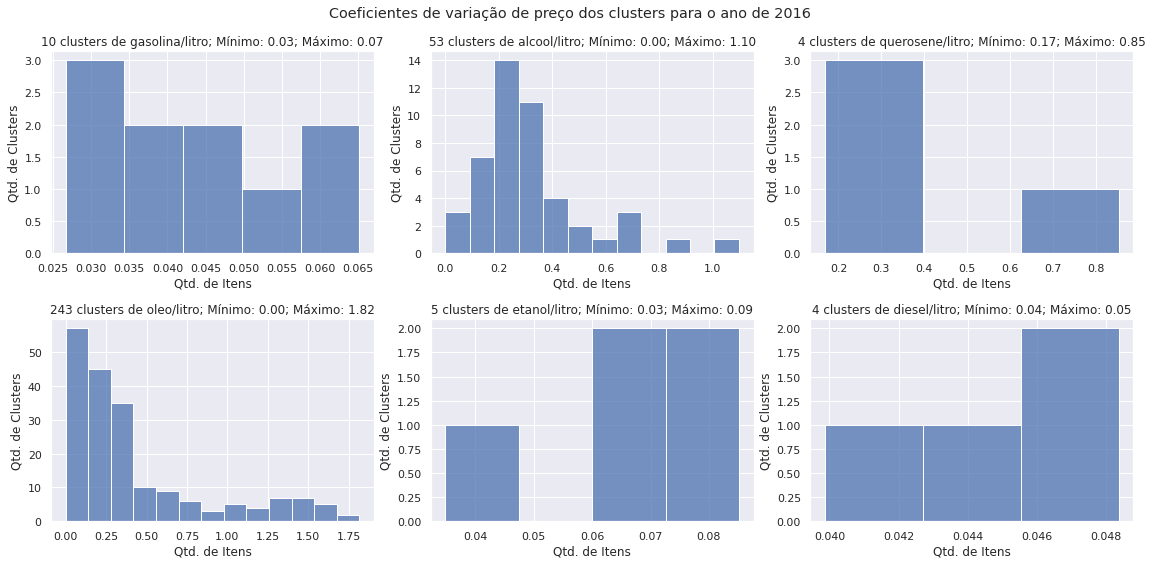

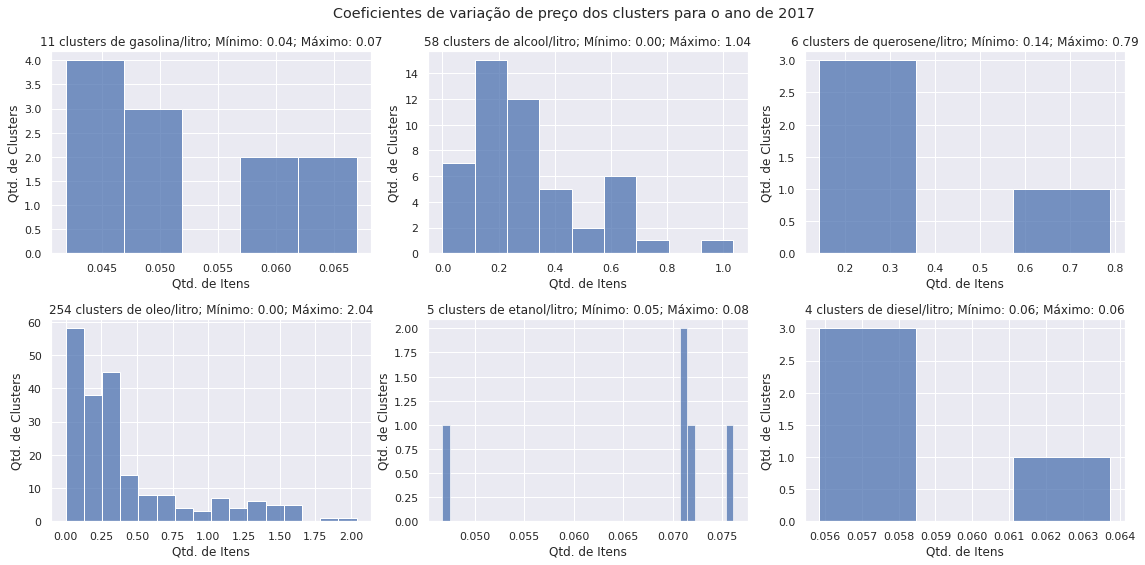

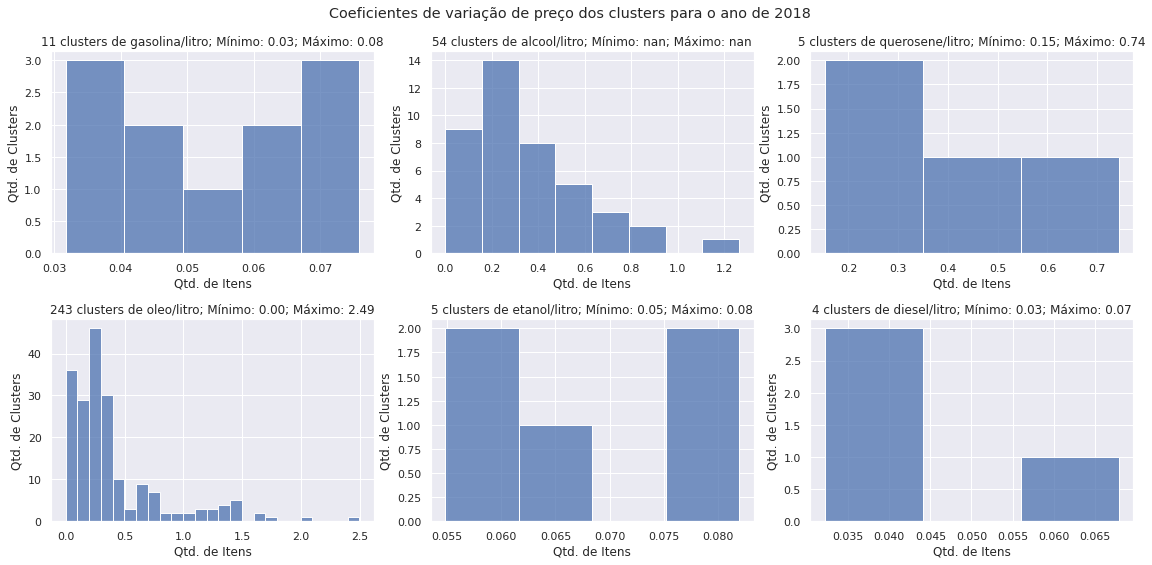

In [72]:
for ano in np.sort(clusters.ano.unique()):
    fig, axs = plt.subplots(2, 3, figsize=(16,8))
    for ax, termo in zip(axs.flat, termos):
        clusters_termo = clusters[(clusters.cluster.str.startswith(termo)) & (clusters.ano == ano)]
        unidade = "litro"
        clusters_termo = clusters_termo[clusters_termo.dsc_unidade_medida == unidade]
        cv = clusters_termo["std"] / clusters_termo["mean"]
        sns.histplot(x=cv, ax=ax)
        ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}/{}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, unidade, min(cv), max(cv)))
    fig.suptitle("Coeficientes de variação de preço dos clusters para o ano de {}".format(ano))
    fig.tight_layout()
    plt.show()